# Gamma-ray bursts prompt emission

- Dynamics:
    - Internal shock in a relativistic jet
- Emission (shock acceleration, synchrotron)

## Step 1: dynamics

In [108]:
from queue import PriorityQueue
import numpy as np
import matplotlib.pyplot as plt

# SI units
second = 1
year = 365*24*3600 * second
speed_of_light = 299792458
mass_proton = 1.673e-27
mass_electron = 9.11e-31
mu_0 = 4 * np.pi * 1e-7
e_charge = 1.602e-19
hbar = 1.0546e-34

class RelativisticShell:

    def __init__(self, rapidity, mass=1, initial_position=0, initial_time=0, lcoord=None):
        self.rapidity = rapidity
        self.gamma = np.cosh(rapidity)
        self.betagamma = np.sinh(rapidity)
        self.speed = speed_of_light * np.tanh(rapidity)
        self.mass = mass
        self.initial_position = initial_position
        self.initial_time = initial_time
        self.alive = True
        self.lcoord = lcoord
    
    def position(self, time):
        return self.initial_position + self.speed * (time - self.initial_time)
    
    def momentum(self):
        return self.mass * speed_of_light * self.gamma
    
    def kill(self):
        self.alive = False


class Emission:
    def __init__(self, time, energy, position, shell_rapidity, s1, s2, simu):
        self.time = time
        self.energy = energy
        self.position = position
        self.shell_rapidity = shell_rapidity
        self.simu = simu

        self.gamma = np.cosh(shell_rapidity)
        self.gamma1 = s1.gamma
        self.gamma2 = s2.gamma
        self.gamma_r = np.sqrt(s1.gamma * s2.gamma)
        self.beta = np.tanh(shell_rapidity)
        self.doppler_shift = np.sqrt((1+self.beta)/(1-self.beta))
        self.arrival_time = time - position / speed_of_light

        # quantities in comoving frame
        self.mass = s1.mass + s2.mass
        self.mass_min = min(s1.mass, s2.mass)
        self.e_int_actual = (s1.mass * s1.gamma + s2.mass * s2.gamma)/self.gamma - self.mass * speed_of_light**2
        self.e_star = ((np.sqrt(self.gamma1 / self.gamma2) + np.sqrt(self.gamma2/self.gamma2))/2 - 1)*speed_of_light**2
        #self.e_star = e_int_actual / self.mass # actual expression of e_star, unused
        self.rho_star = simu.energy_args['rate'] / (simu.mean_gamma * speed_of_light**2)
        self.u_star = self.rho_star * self.e_star

        # other quantities for each emission to be computed later in
        # compute_shocked_matter() and compute_synchrotron()
    
    def compute_shocked_matter(self, p=2.2, zeta=0.5):
        self.gamma_m = (p - 2)/(p - 1) * mass_proton/mass_electron * self.e_star/(3*zeta)
        self.normalization_ngamma = (p - 1) * zeta * self.rho_star/mass_proton * self.gamma_m**(p-1)
        self.B_field = np.sqrt(2 * mu_0 * self.u_star / 3)

    # to be run after compute_shocked_matter()
    def compute_synchrotron(self, p=2.2):
        self.tp_dyn = self.position / (self.gamma_r * speed_of_light)
        K1B = e_charge * self.B_field / (2 * np.pi * mass_electron)
        self.gamma_c = self.tp_dyn * mass_electron * speed_of_light**2 / (K1B * self.B_field)
        self.nu_m = K1B * self.gamma_m**2
        self.nu_c = K1B * self.gamma_c**2

    # Fraction of energy between two frequencies
    # to be run after compute_synchrotron
    def energy_frac(self, lowerlim, upperlim, p=2.2):
        nu_c, nu_m = self.nu_c, self.nu_m
        
        # Normalization constants in regions B and C
        normB = nu_c**(5/6)
        normC = normB * nu_m**(-(p+1)/2)

        # Domain is divided in regions A, B, C
        # There are six possibilities
        def aa(lowerlim, upperlim):
            return 3/4 * (upperlim**(4/3) - lowerlim**(4/3))
        
        def bb(lowerlim, upperlim):
            return 2*normB * (upperlim**(-1/2) - lowerlim**(-1/2))
        
        def cc(lowerlim, upperlim):
            return 2*normC/(2-p) * (upperlim**(1-p/2) - lowerlim**(1-p/2))
        
        def ab(lowerlim, upperlim):
            return aa(lowerlim, nu_c) + bb(nu_c, upperlim)
        
        def ac(lowerlim, upperlim):
            return aa(lowerlim, nu_c) + bb(nu_c, nu_m) + cc(nu_m, upperlim)
        
        def bc(lowerlim, upperlim):
            return bb(lowerlim, nu_m) + cc(nu_m, upperlim)
        
        if lowerlim < nu_c:
            if upperlim < nu_c:
                f = aa
            elif upperlim < nu_m:
                f = ab
            else:
                f = ac
        elif lowerlim < nu_m:
            if upperlim < nu_m:
                f = bb
            else:
                f = bc
        else:
            f = cc

        return f(lowerlim, upperlim) / ac(0, np.infty)

    
    def energy_between(self, lowerlim, upperlim):
        return self.energy * self.energy_frac(lowerlim, upperlim)


class Event:
    def __init__(self, time, simulation):
        self.time = time
        self.simulation = simulation
    
    def process(self, verbose=True):
        pass

    def __lt__(self, other):
        return self.time < other.time

# Production of a shell
class ProductionEvent(Event):
    def __init__(self, time, simulation, rapidity, mass=1, initial_position=0, lcoord=None):
        super().__init__(time, simulation)
        self.rapidity = rapidity
        self.mass = mass
        self.initial_position = initial_position
        self.lcoord = lcoord
    
    def process(self, verbose=True):
        shell = RelativisticShell(self.rapidity, self.mass, self.initial_position, self.time, lcoord=self.lcoord)
        self.simulation.time = self.time

        # find where to put this shell in the shell list
        done = False
        index = -1
        for i, s in enumerate(self.simulation.shells):
            if s.position(self.time) >= self.initial_position:
                self.simulation.shells.insert(i, shell)
                index = i
                done = True
                break
        if not done:
            index = len(self.simulation.shells)
            self.simulation.shells.append(shell)

        # compute new possible collisions with adjacent shells
        if  0 <= index-1:
            anterior = self.simulation.shells[index-1]
            self.simulation.predict_collision(self.time, anterior, shell)
        if index+1 < len(self.simulation.shells):
            posterior = self.simulation.shells[index+1]
            self.simulation.predict_collision(self.time, shell, posterior)


# Collision of two shells
class CollisionEvent(Event):
    def __init__(self, time, simulation, s1, s2):
        super().__init__(time, simulation)
        self.s1 = s1
        self.s2 = s2

    def process(self, verbose=True):
        self.simulation.time = self.time

        s1, s2 = self.s1, self.s2

        # check if shells are still alive
        if not s1.alive or not s2.alive:
            return

        # check that positions are indeed equal
        tol = 1e-5 * speed_of_light
        assert abs(s1.position(self.time) - s2.position(self.time)) < tol, "Precision problems"
        
        # remove shells from list and kill them
        self.simulation.shells.remove(s1)
        self.simulation.shells.remove(s2)
        s1.kill()
        s2.kill()

        # compute parameters of new shell
        mass, rapidity, position, lcoord = self.simulation.compute_new_shell(self.time, s1, s2)
        if verbose:
            print(f"mass={mass}, rapidity={rapidity}, position={position}")

        # produce new shell
        e = ProductionEvent(self.time, self.simulation, rapidity, mass, position, lcoord=lcoord)
        e.process(verbose=verbose)

        # compute emitted energy
        emitted_energy = self.simulation.compute_energy_emission(s1, s2, mass, rapidity)
        self.simulation.emissions.append(Emission(self.time, emitted_energy, position, rapidity, s1, s2, self.simulation))

        # register collision data
        # (time, position, mass1, mass2, mass, speed1, speed2, speed)
        data = (self.time, position, s1.mass, s2.mass, mass, s1.rapidity, s2.rapidity, rapidity)
        self.simulation.collisions.append(data)

########## Initial rapidity functions ###########
def rapidity_profile1(t, gamma_min=100, gamma_max=200, compression=8):
    return np.arccosh((gamma_max-gamma_min) * (1 / np.pi * np.arctan(compression*(t-0.5))+0.5) + gamma_min)

@np.vectorize
def rapidity_profile2(t, gamma_min=100, gamma_max=200):
    if t < 0.5: return np.arccosh(gamma_min)
    return np.arccosh(gamma_max)

def rapidity_profile3(t, gamma_min=100, gamma_max=200):
    return gamma_min + t * (gamma_max-gamma_min)

########## Energy production functions ##########
def energy_profile1(t, rate=1):
    return rate   # constant energy

######## Emission profiles ########
@np.vectorize
def emission_profile1(t, boxsize=0.03):       # ad-hoc box profile
    if 0 <= t and t < boxsize:
        return 1/boxsize
    return 0

@np.vectorize
def emission_profile2(t, boxsize=0.03):
    if 0 <= t and t < boxsize:
        return 2/boxsize * (1 - t/boxsize)
    return 0

class Simulation:
    def __init__(self, rapidity_profile, energy_profile, injection_time=5, injection_interval=0.001,
                rapidity_args={}, energy_args={}):
        self.shells = []                # list of shells in spatial order (leftmost shell at index 0)
        self.queue = PriorityQueue()    # queue of events (productions and collisions)
        self.emissions = []             # list of emissions represented by Emission objects
        self.collisions = []            # list of collisions (time, position, mass1, mass2, mass,
                                        # rapidity1, rapidity2, rapidity)

        self.rapidity_profile = rapidity_profile
        self.energy_profile = energy_profile
        self.rapidity_args = rapidity_args

        if 'rate' not in energy_args:
            energy_args['rate'] = 1
        self.energy_args = energy_args

        self.injection_time = injection_time
        self.injection_interval = injection_interval
        self.injections = np.arange(0, injection_time, injection_interval)

        self.time = 0

        # Put production/injection events in queue
        self.injected_mass = 0
        gamma_sum = 0
        for time in self.injections:
            rapidity = rapidity_profile(time/injection_time, **rapidity_args)
            gamma_sum += np.cosh(rapidity)
            energy_per_time = energy_profile(time/injection_time, **energy_args)
            mass = energy_per_time / np.cosh(rapidity) / speed_of_light**2 * injection_interval

            lcoord = [self.injected_mass]
            self.injected_mass += mass
            lcoord.append(self.injected_mass)

            e = ProductionEvent(time, self, rapidity, mass, lcoord=lcoord)
            self.queue.put(e)
        self.mean_gamma = gamma_sum / len(self.injections)

    
    def run(self, amount=None, verbose=False):
        if amount is None:
            while not self.queue.empty():
                event = self.queue.get()
                event.process(verbose=verbose)
        
        else:
            for _ in range(amount):
                if self.queue.empty():
                    return
                event = self.queue.get()
                event.process(verbose=verbose)
    
    def generate_run(self, stop_every=100, verbose=False):
        while not self.queue.empty():
            self.run(amount=stop_every, verbose=verbose)
            yield self
    
    def compute_emissions(self):
        for e in self.emissions:
            e.compute_shocked_matter()
            e.compute_synchrotron()

    # collision of shell 1 and shell 2 gives shell with new parameters
    def compute_new_shell(self, now, s1, s2):
        
        mass = s1.mass + s2.mass
        beta = (s1.mass * s1.betagamma + s2.mass * s2.betagamma) / (s1.mass * s1.gamma + s2.mass * s2.gamma)
        rapidity = np.arctanh(beta)
        
        position = (s1.position(now) + s2.position(now)) / 2

        lcoord = [s2.lcoord[0], s1.lcoord[1]]

        return mass, rapidity, position, lcoord

    # energy lost in inelastic collision to be emitted
    def compute_energy_emission(self, s1, s2, mass, rapidity):

        energy_before = (s1.mass * s1.gamma + s2.mass * s2.gamma) * speed_of_light**2
        energy_after = mass * np.cosh(rapidity) * speed_of_light**2

        return energy_before - energy_after

    # this is pure kinematics in lab frame
    def predict_collision(self, now, s1, s2):
        if s1.rapidity > s2.rapidity:
            deltax = s2.position(now) - s1.position(now)
            deltav = s1.speed - s2.speed
            collision_time = now + deltax / deltav

            self.queue.put(CollisionEvent(collision_time, self, s1, s2))
        
        
def plot_rapidity_initial(simu, ax=None):
    t = np.linspace(0,1,101)

    if ax is not None:
        plt.sca(ax)
    plt.plot(t * simu.injection_time, simu.rapidity_profile(t, **simu.rapidity_args))
    plt.title("Rapidity profile")
    plt.xlabel("Time of shell production")
    plt.ylabel("Shell rapidity")
    if ax is None:
        plt.show()

def plot_gamma_initial(simu, ax=None):
    t = np.linspace(0,1,301)
    if ax is not None:
        plt.sca(ax)
    plt.plot(t * simu.injection_time, np.cosh(simu.rapidity_profile(t, **simu.rapidity_args)))
    plt.title("Gamma profile")
    plt.xlabel("Time of shell production")
    plt.ylabel("Shell gamma factor")
    if ax is None:
        plt.show()
    


def plot_emissions(simu, axes=None):
    t_init = simu.emissions[0].arrival_time

    emission_time = [e.time for e in simu.emissions]
    arrival_time = [e.arrival_time-t_init for e in simu.emissions]
    emission_position = [e.position for e in simu.emissions]
    emission_gamma_r = [e.gamma_r for e in simu.emissions]
    emission_deltat = np.asarray(emission_position) / (2 * np.asarray(emission_gamma_r)**2 * speed_of_light)
    emission_energy = [e.energy for e in simu.emissions]

    if axes is not None:
        ax1, ax3 = axes
    else:
        fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(4,8))
    plt.tight_layout()
    ax2 = ax1.twinx()
    ax4 = ax3.twinx()

    ax1.scatter(arrival_time, emission_time, marker='.', s=0.5)
    ax1.set_ylabel("$t_e$ (s)")
    ax2.scatter(arrival_time, emission_deltat, marker='.', s=0.5, color='k')
    ax2.set_ylabel("$\\Delta t$ (s)")

    ax3.scatter(arrival_time, emission_energy, marker='.', s=0.5)
    ax3.set_ylabel("e")
    ax4.scatter(arrival_time, emission_gamma_r, marker='.', s=0.5, color='k')
    ax4.set_ylabel("$\\Gamma_r$")

    if axes is None:
        plt.show()


def plot_collisions(simu, ax=None):
    collisions = np.asarray(simu.collisions)
    time = collisions[:,0]
    position = collisions[:,1]

    if ax is not None:
        plt.sca(ax)
    plt.scatter(time, position, marker='.')
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.title("Locus of collisions")
    plt.yscale("log")
    plt.xscale("log")
    if ax is None:
        plt.show()

def lcoord2plottable(lcoords, quantities):
    res = []
    for lcoord, qtty in zip(lcoords, quantities):
        res.append((lcoord[1], qtty))
        res.append((lcoord[0], qtty))
    return np.asarray(res).T

def plot_gamma(simu, ax=None):
    lcoords = [shell.lcoord for shell in simu.shells]
    gammas = [shell.gamma for shell in simu.shells]
    x, y = lcoord2plottable(lcoords, gammas)

    if ax is not None:
        plt.sca(ax)
    plt.plot(x, y)
    plt.xlabel("Lagrangian coordinate")
    plt.ylabel("Gamma factor")
    plt.title(f"Gamma factor distribution, t={simu.time}")
    if ax is None:
        plt.show()

In [103]:
simu = Simulation(rapidity_profile1, energy_profile1,
                rapidity_args=dict(gamma_min=100, gamma_max=400))

simu.run()

# for snapshot in simu.generate_run(stop_every=2500):
#     try:
#         plot_gamma(snapshot)
#     except:
#         pass


In [104]:
simu.compute_emissions()

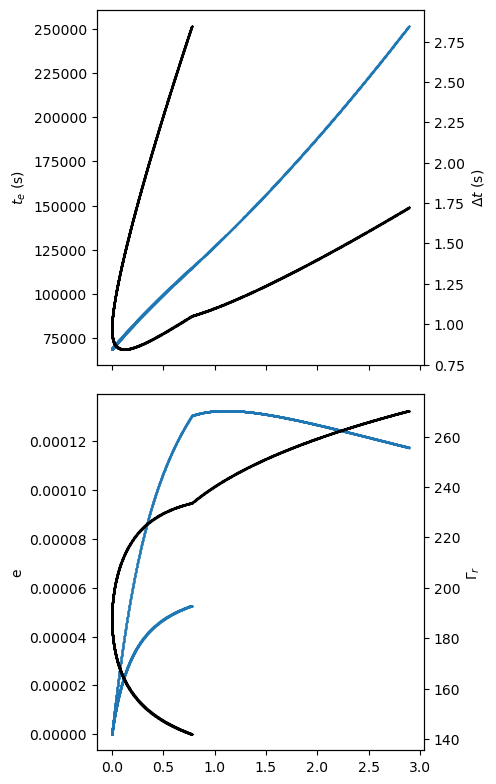

In [105]:
plot_emissions(simu)

In [111]:
def plot_burst_profile(simu, lowerlim=0, upperlim=np.infty, emission_profile=emission_profile2,
                       maxtime=None, npoints=501, emission_args={}, ax=None, label=None):
    t_init = simu.emissions[0].arrival_time
    if maxtime:
        t_end = t_init + maxtime
    else:
        t_end = simu.emissions[-1].arrival_time

    t = np.linspace(t_init, t_end, npoints)

    burst = 0 * t
    for e in simu.emissions:
        energy = e.energy_between(lowerlim, upperlim)
        dt_obs = e.position / (2 * e.gamma_r**2 * speed_of_light)
        burst += energy * emission_profile(t - e.arrival_time, boxsize=dt_obs, **emission_args)

    if ax is not None:
        plt.sca(ax)

    plt.plot(t-t_init, burst, label=label)
    plt.title("Received energy per unit time")
    plt.xlabel("Arrival time $t_{obs} (s)$")
    plt.ylabel("Received energy")
    
    if ax is None:
        plt.show()


def plot_multiple_burst_profiles(simu, lims=[(0, np.infty)], labels=[None], emission_profile=emission_profile2,
                                 maxtime=None, npoints=501, emission_args={}, ax=None):    
    if ax is not None:
        plt.sca(ax)
    
    for (lowerlim, upperlim), label in zip(lims, labels):
        plot_burst_profile(simu, lowerlim, upperlim, emission_profile, maxtime, npoints, emission_args, plt.gca(), label)

    plt.legend()
    if ax is None:
        plt.show()

def standard_bolometric_plot(simu, emission_profile=emission_profile2, maxtime=None, npoints=501):
    const = e_charge / (2 * np.pi * hbar)
    nu_25keV = const * 25e3
    nu_50keV = const * 50e3
    nu_100keV = const * 100e3
    nu_300keV = const * 300e3
    nu_1MeV = const * 1e6

    lims = [(nu_25keV, nu_50keV), (nu_50keV, nu_100keV), (nu_100keV, nu_300keV), (nu_300keV, nu_1MeV)]
    labels = ['25 keV - 50 keV', '50 keV - 100 keV', '100 keV - 300 keV', '300 keV - 1 MeV']

    plot_multiple_burst_profiles(simu, lims, labels, emission_profile, maxtime, npoints)


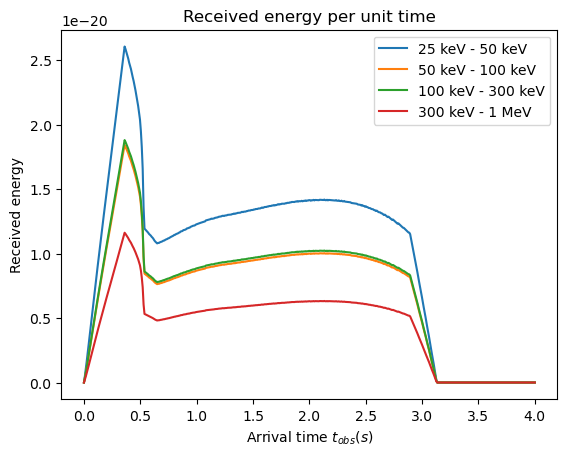

In [112]:
standard_bolometric_plot(simu, maxtime=4, npoints=500)

In [115]:
2*np.pi*hbar * simu.emissions[0].nu_c / e_charge

4.6619441001712415e-28

In [116]:
2*np.pi*hbar * simu.emissions[0].nu_m / e_charge

4.230844527464246e+20

In [118]:
simu.emissions[0].energy_frac(simu.emissions[0].nu_c, simu.emissions[0].nu_m)

1.0000000000000422

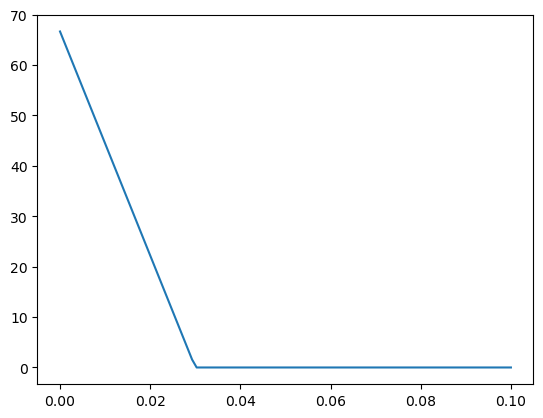

In [82]:
t = np.linspace(0, 0.1, 100)
plt.plot(t, emission_profile2(t))
plt.show()

In [39]:
len(simu.emissions)

4

In [46]:
simu.emissions[0].position / speed_of_light

68542.93118552773